# Check GPU options

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6620015186636899200
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3059115623
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9141494283875175168
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:03:00.0, compute capability: 7.5"
]


# Import needed libraries

In [2]:
# Import general purpose python libraries
import os
import matplotlib.pyplot as plt
from PIL import Image # For handling the images
import numpy as np
from sklearn import metrics
import pandas as pd
# Import different Keras functionalities
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,Model,load_model
from keras.layers import Dense,Flatten,Dropout,concatenate,Input
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.optimizers import SGD,Adagrad
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.applications import ResNet50,Xception,VGG16,VGG19
from keras.preprocessing.image import ImageDataGenerator  

####
# Where to save the figures
IMAGES_PATH = "../images"
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
from utils import saveFigures,write_json,create_json,load_previous_weights

os.chdir("./models/")
from vgg16 import VGG16
os.chdir("../")

Using TensorFlow backend.


# Visualize data

In [3]:
cifar10 = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

In [4]:
X_train_full.shape

(50000, 32, 32, 3)

In [5]:
X_train_full.dtype

dtype('uint8')

In [6]:
X_valid, X_train = X_train_full[:15000] / 255., X_train_full[35000:] / 255.
y_valid, y_train = y_train_full[:15000], y_train_full[35000:]
X_test = X_test / 255.
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

print("num_training_samples: ", X_train.shape)

num_training_samples:  (15000, 32, 32, 3)


In [7]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]


Saving figure cifar10_plot


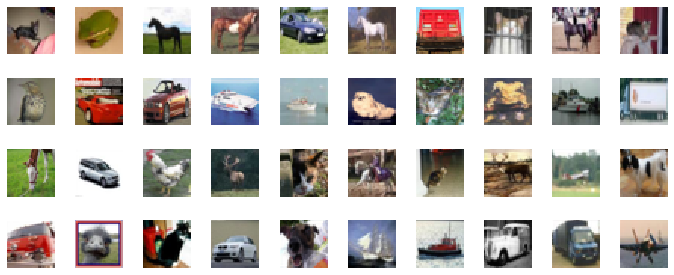

In [9]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        #plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('cifar10_plot', tight_layout=False)
plt.show()

# Configuration parameters
Configuration values of different parts of the solution. You should change some of them to obtain better results.

In [10]:
from datetime import datetime
# Randomize the initial network 
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


# Directory where to store weights of the model and results
now = datetime.now()
current_time = now.strftime("%d_%H_%M_%S")
experiment_rootdir = "./test/"+current_time+"/"
weights_path = experiment_rootdir +"weights.h5"
json_path = experiment_rootdir +"experiment.json"

# Create experiment directory if it does not exists
if not os.path.exists(experiment_rootdir):
    os.makedirs(experiment_rootdir)



In [11]:
# Parameters that configures the training process
name_model = "Prueba"
batch_size = 20 # Batch size
epochs = 1 #Number of epochs
initial_epoch = 0 # Initial epoch, it can be greater than 0 if you want to contiue a previous training process
initial_lr = 1e-4 # Learning rate
num_classes = 10
dropout = 0.5
compile_parameters = { "metrics": ['accuracy'],
                      "optimizer": SGD(learning_rate=0.001, momentum=0.9)}
'''
optimizer=  = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
'''

parameters = {
    "name_model":name_model,
    "compile_parameters" :str(compile_parameters) ,
    "batch_size": batch_size,
    "epochs": epochs, 
    "initial_epoch":initial_epoch, 
    "initial_lr": initial_lr,
    "num_classes": num_classes,
    "dropout": dropout

}
create_json({"parameters":parameters}, json_path)


In [12]:
def trainMode(model,compile_parameters,X_train, y_train, validation_data, epochs, batch_size,experiment_rootdir,weights_path,json_path):
    model.compile(loss='categorical_crossentropy', optimizer=compile_parameters['optimizer'], metrics=compile_parameters['metrics'])
    print(model.summary())
    history = model.fit(x= X_train, y= y_train, validation_data = validation_data, epochs = epochs, batch_size= batch_size)
    model.save_weights(weights_path)
    hist_df = pd.DataFrame(history.history) 
    data = {"train_result2":hist_df.to_dict()}
    write_json(data,json_path)
    return history

# Training 

In [13]:
#Get model
model = VGG16(dropout, num_classes, img_width=32, img_height=32, img_channels=3)
#load weights
load_previous_weights(model,weights_path)
#training model
val = (X_test, y_test)
history =trainMode(model,compile_parameters,X_train, y_train,val, epochs, batch_size,experiment_rootdir,weights_path,json_path)

Impossible to find weight path. Returning untrained model
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
m

In [14]:
saveFigures(experiment_rootdir, history, "accuracy", "loss")

<Figure size 432x288 with 0 Axes>

# Testing

In [ ]:
model = VGG16(dropout, num_classes, img_width=32, img_height=32, img_channels=3)
# Load saved weights
model.compile(loss='categorical_crossentropy', optimizer=compile_parameters['optimizer'], metrics=compile_parameters['metrics'])

y_proba = model.predict(X_test)
y_pred = np.argmax(model.predict(X_test), axis=1)
''' 
# Create groundtruth
gt = np.zeros(y_pred.shape)
init_index = 0
end_index = 0
user_id = 0
for users in sorted(os.listdir(test_dir)):
    user_id = user_id + 1
    if os.path.isdir(os.path.join(test_dir, users)):
        user_path = os.path.join(test_dir, users)
        for root, _, files in sorted(os.walk(user_path)):
            num_images_user = len(files)
            end_index = init_index + num_images_user
            gt[init_index:end_index] = user_id - 1
            init_index = end_index
            
# Evaluate predictions: Average accuracy and highest errors
print("-----------------------------------------------")
print("Evaluation:")
# Compute average accuracy
ave_accuracy = metrics.accuracy_score(gt, y_pred)
print('Average accuracy = ', ave_accuracy)
print("-----------------------------------------------")

# Visualize confusion matrix                                           
plotcm.plotcm(experiment_rootdir, gt, y_pred,class_names, experiment_rootdir, normalize=True)
'''